In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
phi = 0.95
threshold = 0.04
initial_portfolio_value = 100 
cool_off_period = 1  # days
trailing_stop_ratio = 0.05  # 5%
max_drawdown_limit = 0.25  # 25%
risk_free_rate = 0.01  # example risk-free rate

# Retrieve Stock Data
data=pd.read_csv('btcusdt_1h_zelta.csv')
data=data.rename(columns={'open':'Open'})
data['datetime']=pd.to_datetime(data['datetime'])
data=data.set_index('datetime')

# Calculate Moving Averages, RSI, and Golden Ratio Bounds
data['MA50'] = data['Open'].rolling(window=50).mean()
data['MA200'] = data['Open'].rolling(window=200).mean()
data['RSI'] = data['Open'].rolling(window=14).apply(lambda x: np.sum(np.diff(x)[np.diff(x) > 0]) / np.sum(np.abs(np.diff(x))), raw=True)
data['UpperBound_MA50'] = data['MA50'] / phi
data['LowerBound_MA50'] = data['MA50'] * phi
data['UpperBound_MA200'] = data['MA200'] / phi
data['LowerBound_MA200'] = data['MA200'] * phi

# Improved Anomaly Detection
anomalies = []
for index, row in data.iterrows():
    if pd.notna(row['MA50']) and ((row['Open'] < row['UpperBound_MA50']  or row['Open'] > row['LowerBound_MA50']) and row['RSI'] > 0.7):
        anomalies.append((index, row['Open'],row['low']))

# Calculate Rolling Historical Volatility for Dynamic Trade Size
data['Returns'] = data['Open'].pct_change()
data['Volatility'] = data['Returns'].rolling(window=20).std() * np.sqrt(252)  # Annualized volatility

# Trading Strategy Implementation with Trailing Stop Loss
portfolio_value = initial_portfolio_value
trade_history = []
open_position = False
max_drawdown = 0
peak_portfolio_value = initial_portfolio_value
strategy_returns = []
trailing_stop_price = 0
trade_amounta=[]

for date, price,low in anomalies:
    # Dynamic trade size adjustment
 
    if not open_position and date >= data.index[0] + pd.Timedelta(hours=1):
        # Buy logic
        buy_price = price
        buy_date = date
        open_position = True
        peak_price = price
        trailing_stop_price = price * (1 - trailing_stop_ratio)
    elif open_position:
        # Trailing Stop Loss Check
        if low <= trailing_stop_price:
            sell_price = trailing_stop_price
            sell_date = date
            trade_return = (sell_price - buy_price) / buy_price
            strategy_returns.append(trade_return)

            portfolio_value *= (0.998 + trade_return)
            trade_history.append((buy_date, buy_price, sell_date, sell_price, trade_return, portfolio_value, max_drawdown))
            trade_size_percentage = 0.1 / data.loc[date, 'Volatility']
            trade_amount = trade_size_percentage * portfolio_value  
            trade_amounta.append(trade_amount)
            open_position = False
        else:
            # Update Trailing Stop Price
            trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_stop_ratio))
            peak_price = max(peak_price, price)

        # Update Max Drawdown
        current_drawdown = (peak_portfolio_value - portfolio_value) / peak_portfolio_value
        max_drawdown = max(max_drawdown, current_drawdown)
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)

    if not open_position:
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)
        current_drawdown = (peak_portfolio_value - portfolio_value) / peak_portfolio_value
        max_drawdown = max(max_drawdown, current_drawdown)

# Handle the open position as required
# ... [rest of the code for finalizing trade history and calculating ratios]
# Check for open position not closed
if open_position:
    # Handle the open position as required
    trade_history.append((buy_date, buy_price, 'Not Sold', 'N/A', 'N/A', portfolio_value, max_drawdown))

# Convert trade history to DataFrame
trade_df = pd.DataFrame(trade_history, columns=['Buy Date', 'Buy Price', 'Sell Date', 'Sell Price', 'Trade Return', 'Portfolio Value', 'Max Drawdown'])

# Calculate Sharpe and Sortino Ratios for Strategy
strategy_std_dev = np.std(strategy_returns)
strategy_mean_return = np.mean(strategy_returns)
sharpe_ratio = (strategy_mean_return - risk_free_rate) / strategy_std_dev if strategy_std_dev != 0 else 0
sortino_ratio = (strategy_mean_return - risk_free_rate) / np.std([r for r in strategy_returns if r < 0]) if any(r < 0 for r in strategy_returns) else 0

# Add ratios to the summary table
trade_df['Sharpe Ratio'] = sharpe_ratio
trade_df['Sortino Ratio'] = sortino_ratio
trade_df['trade amount']=pd.Series(trade_amounta)
# Display the DataFrame
trade_df

,Buy Date,Buy Price,Sell Date,Sell Price,Trade Return,Portfolio Value,Max Drawdown,Sharpe Ratio,Sortino Ratio,trade amount
0,2018-01-03 06:30:00,14758.01,2018-01-09 09:30:00,16173.7785,0.095932,109.393221,0.000000,0.315438,2.993314,20.861163
1,2018-01-09 10:30:00,15349.00,2018-01-11 03:30:00,14581.5500,-0.050000,103.704773,0.000000,0.315438,2.993314,32.234960
2,2018-01-11 05:30:00,14940.00,2018-01-13 11:30:00,14193.0000,-0.050000,98.312125,0.052000,0.315438,2.993314,42.216040
3,2018-01-13 13:30:00,14250.00,2018-01-19 21:30:00,13794.0000,-0.032000,94.969513,0.101296,0.315438,2.993314,27.745003
4,2018-01-20 10:30:00,12344.90,2018-01-24 19:30:00,12183.7500,-0.013054,93.539844,0.131852,0.315438,2.993314,41.759821
...,...,...,...,...,...,...,...,...,...,...
133,2021-11-29 04:30:00,56029.81,2021-12-05 02:30:00,55609.5895,-0.007500,43982.675628,0.199366,0.315438,2.993314,16509.679227
134,2021-12-05 06:30:00,48944.69,2021-12-10 19:30:00,48743.6450,-0.004108,43714.047226,0.199366,0.315438,2.993314,41617.209139
135,2021-12-11 18:30:00,48517.58,2021-12-15 12:30:00,47945.2745,-0.011796,43110.975325,0.199366,0.315438,2.993314,42914.780119
136,2021-12-15 13:30:00,48209.51,2021-12-30 18:30:00,49260.4450,0.021799,43964.543736,0.199366,0.315438,2.993314,46890.891279


In [30]:
pd.Series(strategy_returns).describe()

count    138.000000
mean       0.054831
std        0.142640
min       -0.050000
25%       -0.032844
50%        0.002389
75%        0.074824
max        0.775420
dtype: float64

In [31]:
len(anomalies)

5052

<Axes: >

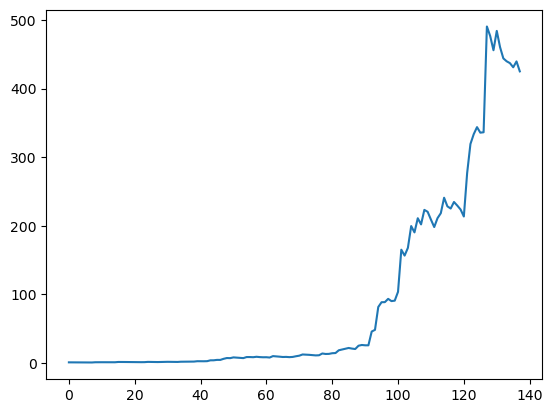

In [32]:
cumulative_returns=0.998+np.array(strategy_returns)
for i in range(1,len(cumulative_returns)):
    cumulative_returns[i]*=cumulative_returns[i-1]
sns.lineplot(cumulative_returns)

In [33]:
cumulative_returns[-1]

425.1374872670522

In [34]:
trade_df['PNL']=trade_df['Trade Return']*trade_df['trade amount']

In [35]:
trade_df['cumPNL']=trade_df['PNL'].cumsum()

<Axes: >

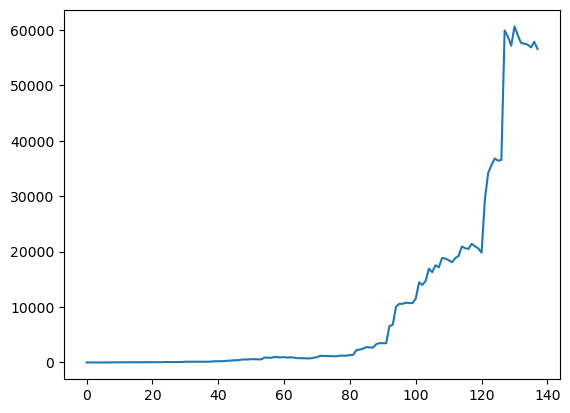

In [36]:
trade_df['cumPNL'].plot()

In [37]:
data['signal']=0

In [38]:
for i in trade_df['Buy Date']:
    data['signal'].loc[i]=1
for i in trade_df['Sell Date']:
    data['signal'].loc[i]=-1

C:\Users\sagni\AppData\Local\Temp\ipykernel_22032\78111762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'].loc[i]=1
C:\Users\sagni\AppData\Local\Temp\ipykernel_22032\78111762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'].loc[i]=1
C:\Users\sagni\AppData\Local\Temp\ipykernel_22032\78111762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'].loc[i]=1
C:\Users\sagni\AppData\Local\Temp\

In [39]:
final_df=data[['Open','high','low','close','volume','signal']]

In [40]:
data=data.reset_index()

In [45]:
data.rename(columns={'datetime':'timestamp','Open':'open'},inplace=True)

In [47]:
final_df=data[['timestamp','signal','open','high','low','close','volume']]

In [58]:
final_df.rename(columns={'signal':'signals','timestamp':'datetime'},inplace=True)

C:\Users\sagni\AppData\Local\Temp\ipykernel_22032\2250103625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'signal':'signals','timestamp':'datetime'},inplace=True)


In [59]:
final_df.to_csv('log_1.csv',index=False)

In [60]:
final_df

,datetime,signals,open,high,low,close,volume
0,2018-01-01 05:30:00,0,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,0,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,0,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,0,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,0,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...,...
35203,2022-01-12 01:30:00,0,42972.04,43095.26,42692.19,42800.38,1219.601780
35204,2022-01-12 02:30:00,0,42797.62,42823.69,42643.74,42659.20,702.103800
35205,2022-01-12 03:30:00,0,42664.71,42776.14,42597.41,42713.13,561.859930
35206,2022-01-12 04:30:00,0,42713.12,42886.28,42633.97,42729.29,681.142010
